## GMU gates analysis

In [82]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gates = np.load('model_save_mmtr/moviescope_VideoTextAudioPosterMetaGMUSeed5_mmtr_model_run/gates.npy')

In [5]:
gates.shape

(987, 3840)

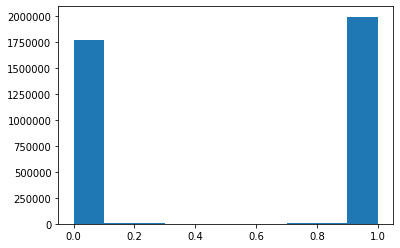

In [87]:
plt.hist(np.ravel(gates))
plt.show()

#### Text

In [6]:
txt_gates = gates[:, :768]

In [13]:
np.mean(np.mean(txt_gates, axis=0))

0.53641474

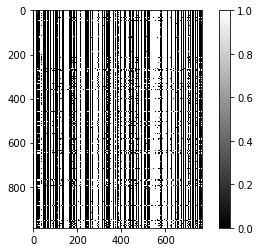

In [97]:
#fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(txt_gates, cmap='gray')
plt.colorbar()
plt.show()

#### Video

In [28]:
vid_gates = gates[:, 768:768*2]

In [29]:
np.mean(np.mean(vid_gates, axis=0))

0.54050523

#### Audio

In [30]:
audio_gates = gates[:, 768*2:768*3]

In [31]:
np.mean(np.mean(audio_gates, axis=0))

0.51183224

#### Image

In [32]:
img_gates = gates[:, 768*3:768*4]

In [33]:
np.mean(np.mean(img_gates, axis=0))

0.536018

#### Metadata

In [34]:
meta_gates = gates[:, 768*4:]

In [35]:
np.mean(np.mean(meta_gates, axis=0))

0.5258729

### Stack predictions of each modality in new axis

In [40]:
all_gates = np.stack([txt_gates, vid_gates, audio_gates, img_gates, meta_gates], axis=1)

In [41]:
all_gates.shape

(987, 5, 768)

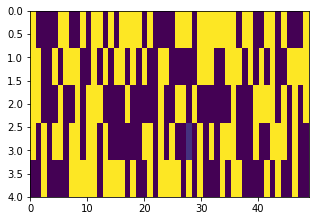

In [150]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

limit = 50
img = plt.imshow(all_gates[0,:,:limit], extent=[0,limit-1,all_gates.shape[1]-1,0])
forceAspect(ax, aspect=1.5)

### Max activation per modality
Get index of modality with maximum value for each dimension:

* max_activation[i,j] $\in \{0,1,2,3,4\}$ for $i = 1,2, ..., N$ and $j = 1,2, ..., 768$

In [47]:
max_activation = np.argmax(all_gates, axis=1)

In [48]:
max_activation.shape

(987, 768)

#### Get frequencies of modality index for each test example (1,2, ..., N)

In [65]:
modality_count = list(map(np.bincount, max_activation))
modality_count = np.array(modality_count)

In [67]:
modality_count.shape

(987, 5)

In [72]:
modality_count[:10]

array([[424, 187,  85,  50,  22],
       [409, 187,  91,  55,  26],
       [424, 187,  85,  50,  22],
       [420, 187,  86,  53,  22],
       [420, 193,  85,  46,  24],
       [423, 185,  86,  50,  24],
       [414, 188,  86,  54,  26],
       [421, 187,  86,  52,  22],
       [423, 186,  86,  51,  22],
       [421, 187,  85,  53,  22]])

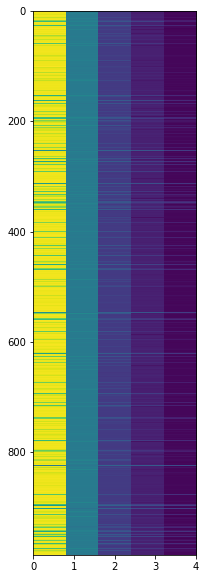

In [126]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

img = plt.imshow(modality_count, extent=[0,4,modality_count.shape[0]-1,0])
forceAspect(ax, aspect=0.3)

In [ ]:
#fig, ax = plt.subplots(figsize=(1, 100))
plt.figure(figsize = (1,100))
plt.imshow(modality_count[:100])
plt.show()

### Frequencies of modality's activation > threshold

In [177]:
from collections import Counter

modality_dist = []
threshold = 0.9

for i in range(all_gates.shape[0]):
    example_modality_freq = []
    for j in range(all_gates.shape[1]):
        modality_true_counts = Counter(all_gates[i][j] > threshold)[True]
        example_modality_freq.append(modality_true_counts)
    modality_dist.append(np.array(example_modality_freq))

modality_dist = np.array(modality_dist)

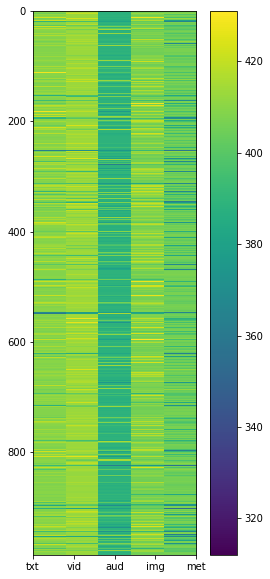

In [184]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    plt.colorbar()

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

img = plt.imshow(modality_dist, extent=[0,4,modality_dist.shape[0]-1,0])
forceAspect(ax, aspect=0.3)
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_xticklabels(modality_xticks);

### Frequencies of modality's activation > threshold for correct predicitons

In [327]:
model_preds = load_labels("model_save_mmtr/moviescope_VideoTextPosterMetaGMUSeed5_mmtr_model_run/test_labels_gold.txt")
ground_truth_labels = load_labels("model_save_mmtr/moviescope_VideoTextPosterMetaGMUSeed5_mmtr_model_run/test_labels_pred.txt")

In [328]:
preds_equal_eval = list(map(np.all, np.equal(model_preds, ground_truth_labels)))
preds_equal_eval = np.array(preds_equal_eval)

In [329]:
correct_indexes = np.argwhere(preds_equal_eval == True)
correct_indexes = np.squeeze(correct_indexes, axis=1)

In [337]:
correct_modality_dist = modality_dist[correct_indexes]

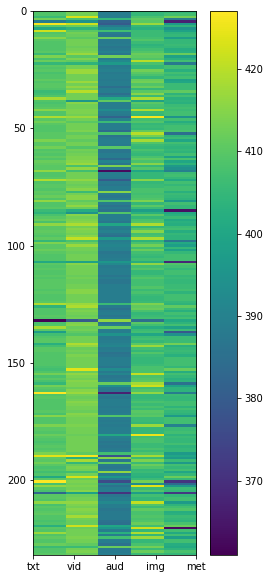

In [338]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    plt.colorbar()

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

img = plt.imshow(correct_modality_dist, extent=[0,4,correct_modality_dist.shape[0]-1,0])
forceAspect(ax, aspect=0.3)
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_xticklabels(modality_xticks);

### Get highest or lowest example index activatons per modality

In [339]:
def get_extreme_index(modality_name, func, modality_dist):
    modality_txt2idx = {'txt': 0,'vid': 1,'aud': 2,'img': 3, 'met': 4}
    
    return func(modality_dist[:, modality_txt2idx[modality_name]])

#### Load test predictions, labels and metadata

In [215]:
def load_labels(path):
    with open(path, "r") as f:
        all_preds = f.readlines()
    preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
    return np.array(preds_processed)

In [221]:
import json
import pandas as pd

metadata_df = pd.read_csv('../moviescope/movie_metadata.csv')
data_labels = [json.loads(line) for line in open('../moviescope/train.jsonl')]

with open("model_save_mmtr/moviescope_VideoTextPosterMetaGMUSeed5_mmtr_model_run/test_labels.txt", "r") as f:
    label_names = f.readlines()[0].split(" ")
    
model_preds = load_labels("model_save_mmtr/moviescope_VideoTextPosterMetaGMUSeed5_mmtr_model_run/test_labels_pred.txt")

#### Get example where audio had the highest frequency

In [257]:
example_id = get_extreme_index("aud", np.argmax)
data_labels[example_id]

{'label': ['Drama', 'Fantasy', 'Horror'],
 'id': 4350,
 'synopsis': 'Alone in her home, Margaret White (Julianne Moore), a religious, yet disturbed woman, gives birth to a baby girl, intending to kill the infant but changes her mind. Years later, her daughter Carrie (Chloë Grace Moretz), a shy, unassertive girl, nears her graduation from Ewen High School in Maine. While showering after gym class at school, Carrie experiences her first menstrual period. She naively thinks she is bleeding to death. The other girls ridicule her, and longtime bully Chris Hargensen (Portia Doubleday) records the event on her smartphone and uploads it to YouTube. Gym teacher Miss Desjardin (Judy Greer) comforts Carrie and sends her home with Margaret, who believes menstruation is a sin. Margaret demands that Carrie abstain from showering with the others. When Carrie refuses, Margaret hits her with a Bible and locks her in her "prayer closet". As Carrie screams to be let out, a crack appears on the door, and 

In [258]:
metadata_df.iloc[data_labels[example_id]['id']]

color                                                                    Color
director_name                                                  Kimberly Peirce
num_critic_for_reviews                                                     359
duration                                                                   100
director_facebook_likes                                                    108
actor_3_facebook_likes                                                     534
actor_2_name                                                        Judy Greer
actor_1_facebook_likes                                                   17000
gross                                                              3.52666e+07
genres                                                    Drama|Fantasy|Horror
actor_1_name                                                Chloë Grace Moretz
movie_title                                                            Carrie 
num_voted_users                                     

In [259]:
model_label_preds = []

for i, value in enumerate(model_preds[example_id]):
    if value == 1:
        model_label_preds.append(label_names[i])
        
ground_truth_labels = metadata_df.iloc[data_labels[example_id]['id']].genres.split('|')
        
print(f"Predicted labels: ", model_label_preds)
print(f"Ground truth labels: ", ground_truth_labels)

Predicted labels:  ['Comedy', 'Drama']
Ground truth labels:  ['Drama', 'Fantasy', 'Horror']


In [260]:
modality_dist[example_id]

array([416, 405, 417, 414, 407])

### Get highest or lowest example index activatons per modality for correct predictions

In [340]:
example_id = get_extreme_index("txt", np.argmin, correct_modality_dist)
data_labels[example_id]

{'label': ['Drama'],
 'id': 3888,
 'synopsis': "Bob Harris, an aging American movie star, arrives in Tokyo to film an advertisement for Suntory whisky. Charlotte, a young college graduate, is left in her hotel room by her husband, John, a celebrity photographer on assignment in Tokyo. Charlotte is unsure of her future with John, feeling detached from his lifestyle and disillusioned about their relationship. Bob's own 25-year marriage is strained as he goes through a midlife crisis. Each day, Bob and Charlotte encounter each other in the hotel, and finally meet at the hotel bar one night when neither can sleep. Eventually Charlotte invites Bob to meet with some local friends of hers. The two bond through a fun night in Tokyo, welcomed without prejudice by Charlotte's friends and experiencing Japanese nightlife and culture. In the days that follow, Bob and Charlotte's platonic relationship develops as they spend more time together. One night, each unable to sleep, the two share an intima

In [342]:
metadata_df.iloc[data_labels[example_id]['id']]

color                                                                    Color
director_name                                                    Sofia Coppola
num_critic_for_reviews                                                     265
duration                                                                   101
director_facebook_likes                                                      0
actor_3_facebook_likes                                                      11
actor_2_name                                                       Bill Murray
actor_1_facebook_likes                                                   19000
gross                                                               4.4566e+07
genres                                                                   Drama
actor_1_name                                                Scarlett Johansson
movie_title                                               Lost in Translation 
num_voted_users                                     

In [347]:
model_label_preds = []

for i, value in enumerate(model_preds[correct_indexes[example_id]]):
    if value == 1:
        model_label_preds.append(label_names[i])
        
ground_truth_labels = metadata_df.iloc[data_labels[example_id]['id']].genres.split('|')
        
print(f"Predicted labels: ", model_label_preds)
print(f"Ground truth labels: ", ground_truth_labels)

Predicted labels:  ['Drama']
Ground truth labels:  ['Drama']


In [348]:
modality_dist[correct_indexes[example_id]]

array([361, 380, 416, 385, 401])